# CLIP-GLaSS

Wellcome to the Google's Colab demo of CLIP-GLaSS.

For faster results we encourage you to use your own GPU.


## Instructions

1) Click the play button of the first block titled "CLIP-GLaSS initialization" and wait for it to finish the initialization

2) Select a config and a target from the form titled "CLIP-GLaSS settings"

3) Click the play button of the block titled "CLIP-GLaSS settings"

## Credits

- Author: Galatolo Federico

- Source https://github.com/galatolofederico/clip-glass


In [1]:
#@title CLIP-GLaSS initialization
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

%cd /content
!git clone https://github.com/galatolofederico/clip-glass.git
%cd clip-glass

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan==0.1.1 pymoo==0.4.2.1 kornia==0.4.1 ftfy==5.8 tensorboard==2.4.1

/content
Cloning into 'clip-glass'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 100 (delta 30), reused 87 (delta 19), pack-reused 0
Receiving objects: 100% (100/100), 2.91 MiB | 3.83 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/clip-glass
     |████████████████████████████████| 3.7 MB 6.5 MB/s 
     |████████████████████████████████| 225 kB 49.3 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 10.6 MB 11.6 MB/s 
     |████████████████████████████████| 131 kB 48.6 MB/s 
     |████████████████████████████████| 239 kB 61.3 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 8.4 MB 36.2 MB/s 
     |████████████████████████████████| 127 kB 39.6 MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.1-cp37-cp37m-linux_x86_64.whl size=1347942 sha256=72ee2c8bf0365b1e4cc95

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |      64 |  0.00000E+00 |  0.00000E+00 |      -0.2664 |      -0.1963
    2 |     128 |  0.00000E+00 |  0.00000E+00 |      -0.2712 |      -0.2162
    3 |     192 |  0.00000E+00 |  0.00000E+00 |      -0.2957 |      -0.2281
    4 |     256 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |      -0.2378
    5 |     320 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |       -0.243
    6 |     384 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |      -0.2515
    7 |     448 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |      -0.2588
    8 |     512 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |      -0.2668
    9 |     576 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |      -0.2734
   10 |     640 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |      -0.2786


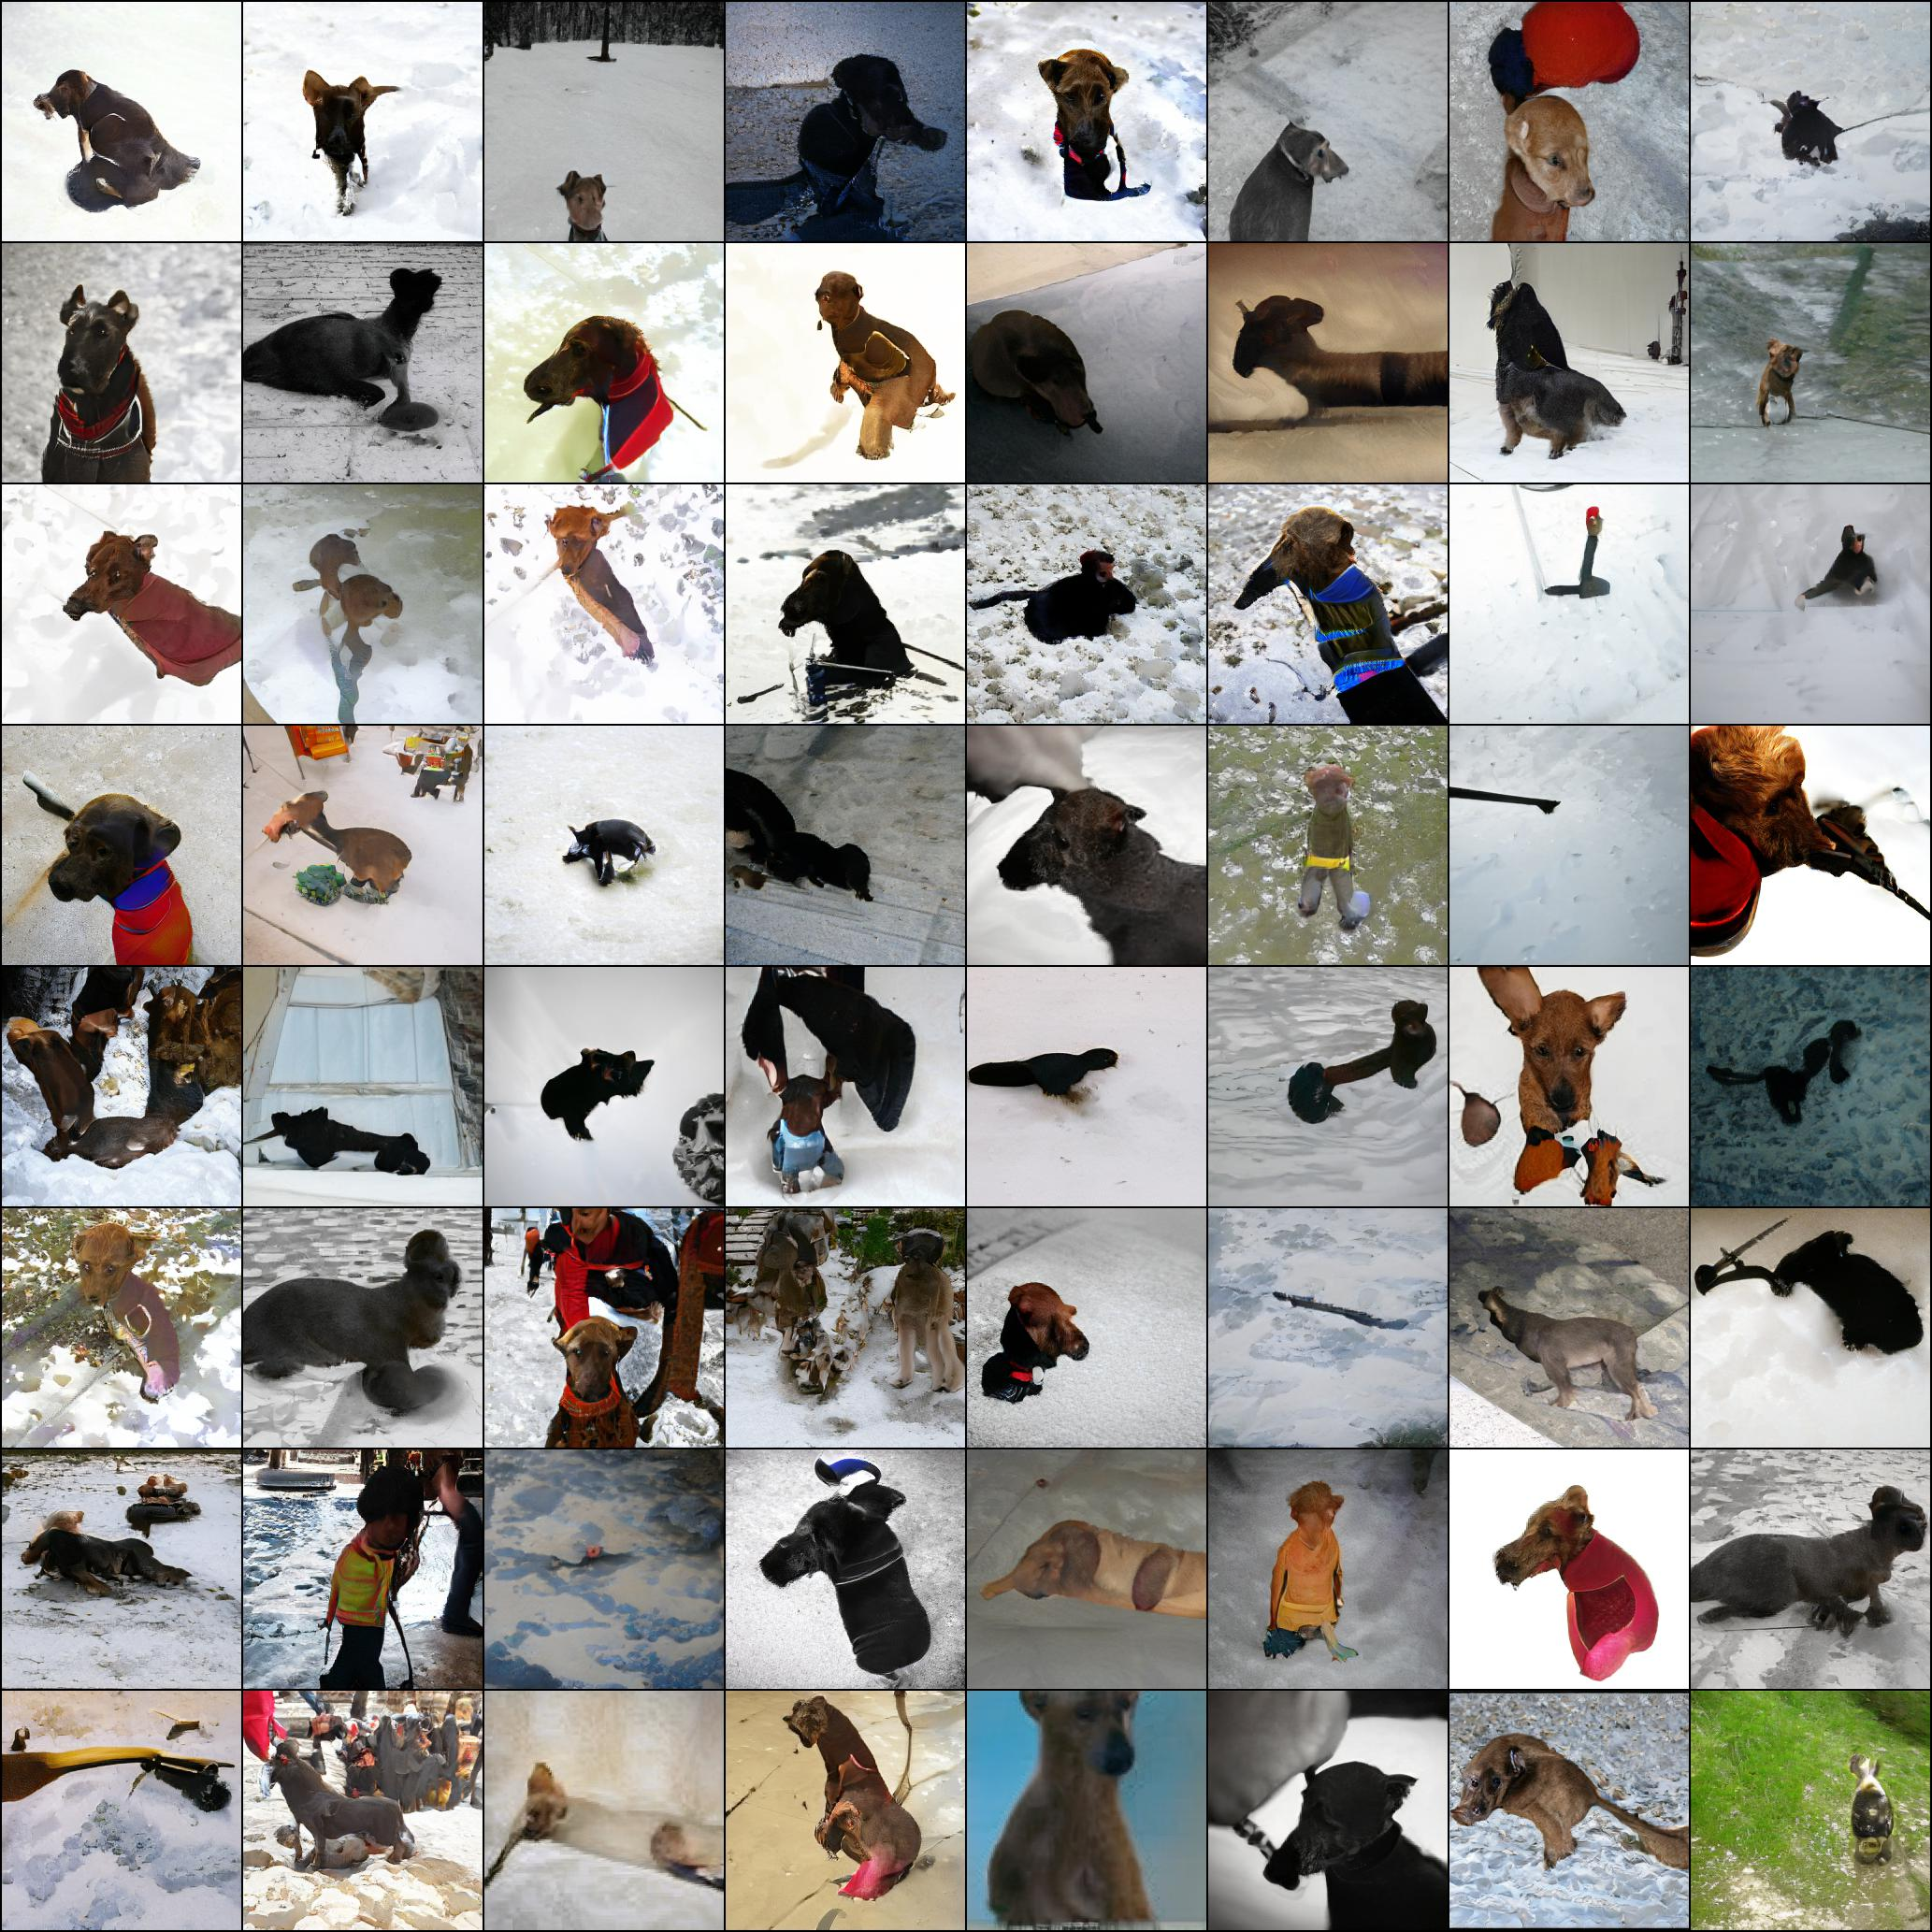

   11 |     704 |  0.00000E+00 |  0.00000E+00 |      -0.3276 |      -0.2834
   12 |     768 |  0.00000E+00 |  0.00000E+00 |      -0.3323 |       -0.288
   13 |     832 |  0.00000E+00 |  0.00000E+00 |      -0.3323 |       -0.293


KeyboardInterrupt: ignored

In [4]:
#@title CLIP-GLaSS settings
import argparse
import os
import torch
import numpy as np
import pickle
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request


from config import get_config
from problem import GenerationProblem
from operators import get_operators

target = "a dog on the snow" #@param {type:"string"}
config = "DeepMindBigGAN256" #@param ["DeepMindBigGAN256", "DeepMindBigGAN512", "StyleGAN2_ffhq_d", "StyleGAN2_car_d", "StyleGAN2_church_d", "StyleGAN2_ffhq_nod", "StyleGAN2_car_nod", "StyleGAN2_church_nod", "GPT2"]
save_each = 10 #@param {type:"number"}
generations = 500 #@param {type:"number"}

if config == "GPT2":
  try:
    urllib.request.urlretrieve(target, "./target")
    target = "./target"
  except Exception as e:
    print(e)
    raise Exception("Target must be a vaild URL when using GPT2")
    

if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if config == "GPT2":
  ! ./download-weights.sh GPT2

config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))


iteration = 0
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])  
        else:
            X = algorithm.pop.get("X")
        
        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            if config.task == "txt2img":
                algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                display(Image(os.path.join(config.tmp_folder, name)))
            elif config.task == "img2txt":
                print("\n".join(generated))
        

problem = GenerationProblem(config)
operators = get_operators(config)

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

algorithm = get_algorithm(
    config.algorithm,
    pop_size=config.pop_size,
    sampling=operators["sampling"],
    crossover=operators["crossover"],
    mutation=operators["mutation"],
    eliminate_duplicates=True,
    callback=save_callback,
    **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", config.generations),
    save_history=False,
    verbose=True,
)


pickle.dump(dict(
    X = res.X,
    F = res.F,
    G = res.G,
    CV = res.CV,
), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


if config.problem_args["n_obj"] == 1:
    X = np.atleast_2d(res.X)
else:
    try:
        result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
    except:
        print("Warning: cant use pseudo-weights")
        result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
    X = res.X[result]
    X = np.atleast_2d(X)

print("="*50)
print("RESULT")
print("="*50)


ls = config.latent(config)
ls.set_from_population(X)

with torch.no_grad():
    generated = problem.generator.generate(ls)

if config.task == "txt2img":
    problem.generator.save(generated, os.path.join(config.tmp_folder, "output.jpg"))
    display(Image(os.path.join(config.tmp_folder, "output.jpg")))
elif config.task == "img2txt":
    print(generated)

